In [1]:
import numpy as N
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime,timedelta
import pytz as pytz
import sys
import os
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import modules.thermolib as thermo
import modules.DSDlib as dsd
import modules.disdrometer_module as dis
import pandas as pd
import glob
import numpy.random as random
from scipy.stats import gamma
from scipy.special import gamma as gammafunc
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Some global parameters
rhoa = 1.0 # kg m^-3
cr = 1000.*N.pi/6.

In [31]:
# Function definitions
def gammaDSD(D, cx,q ,Nt=None, N0=None, alpha=0):
    """Given cx, q, Nt or N0, and alpha, compute the gamma DSD for the sequence of diameters in D"""
    if(N0 is None):
        try:
            N0,_ = dsd.cal_N0(rhoa, q/1000., Nt, cx, alpha)
        except Exception:
            return None
    else:
        try:
            Nt = dsd.cal_Nt(rhoa, q/1000., N0, cx, alpha)
        except Exception:
            return None
        
    lamda = dsd.cal_lamda(rhoa, q/1000., Nt, cx, alpha)
    
    return N0*D**alpha*N.exp(-lamda*D), Nt, lamda, alpha

def samplegammaDSD(Nt, lamda, alpha, bins=None):
    """Randomly samples a gamma DSD given Nt, lamda, and alpha."""
    scale = 1./lamda
    shape = alpha+1.
    s = gamma.rvs(shape, scale, int(Nt))
    # If desired, bin up the resulting samples into the given diameter ranges
    if(bins is None):
        return s
    else:
        ND_sample,_ = N.histogram(s, bins)
        return ND_sample/(bins[1:]-bins[:-1])

def plotDSD(Dl, Dmid, Dr, ND, ax=None):
    """Plots a DSD on a semilog plot"""
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    ax.bar(Dl, ND, Dr-Dl, 10.**2., align='edge', log=True, color='tan', edgecolor = 'k')
    ax.set_yscale('log')
    ax.set_ylim(10.**2., 10.**8.5)
    ax.set_xlim(0., 9.)
    ax.set_xlabel('D (mm)')
    ax.set_ylabel(r'N(D) $(m^{-4})$')
    
    return ax

In [32]:
D = dis.avg_diameter/1000.
Dl = dis.min_diameter/1000.
Dr = dis.max_diameter/1000.

Dedges = N.append(Dl,Dr[-1])
print Dedges

qr = 1.0 # g kg^-1
N0r = 8.0e6 # M-P value (m^-4)

ND, Ntr, lamdar, alphar = gammaDSD(D, cr, qr, N0=N0r)

ND_sample = samplegammaDSD(Ntr, lamdar, alphar, size=100, bins=Dedges)

print ND
print ND_sample

[ 0.        0.000125  0.00025   0.000375  0.0005    0.000625  0.00075
  0.000875  0.001     0.001125  0.00125   0.0015    0.00175   0.002
  0.00225   0.0025    0.003     0.0035    0.004     0.0045    0.005     0.006
  0.007     0.008     0.009     0.01      0.012     0.014     0.016     0.018
  0.02      0.023     0.026   ]
40.2680988414
[  6.95528742e+06   5.25733038e+06   3.97388650e+06   3.00376289e+06
   2.27047036e+06   1.71619260e+06   1.29722770e+06   9.80542454e+05
   7.41167880e+05   5.60230539e+05   3.68164629e+05   2.10349963e+05
   1.20182938e+05   6.86662284e+04   3.92322821e+04   1.69431493e+04
   5.53088834e+03   1.80549232e+03   5.89381365e+02   1.92396494e+02
   3.58837884e+01   3.82384074e+00   4.07475315e-01   4.34212992e-02
   4.62705138e-03   1.60955783e-04   1.82771975e-06   2.07545166e-08
   2.35676153e-10   2.67620056e-12   9.92024574e-15   1.20040268e-17]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


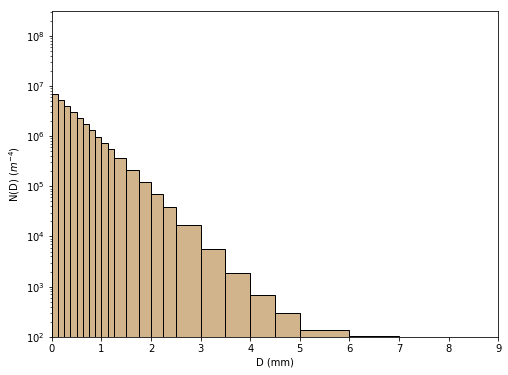

In [5]:
ax = plotDSD(Dl*1000., D*1000., Dr*1000., ND)

(0.0, 0.009)

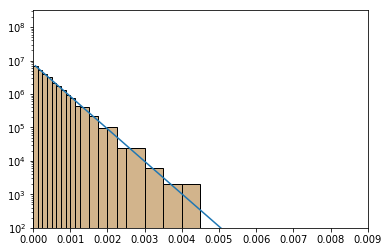

In [81]:
# Compute gamma distribution as a function of total number concentration and the PDF for the middle of each bin
shape = alphar+1
scale = 1./lamdar
x = D
s = Ntr*gamma.pdf(x, shape, scale=scale)

# Now sample the gamma distribution
s_sample = gamma.rvs(shape, scale=scale, size=int(Ntr))
# Bin up the samples into the Parsivel bins
s_binned,_ = N.histogram(s_sample, bins=Dedges)

# For plotting need to divide by the bin widths, since above we get number of drops/unit volume in each bin
# So this gives us number of drops/unit volume/diameter interval
s_sample_plot = s_binned/(Dr-Dl)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, s)
ax.bar(Dl, s_sample_plot, Dr - Dl, 10**2., align='edge', log=True, color='tan', edgecolor='k')
ax.set_yscale('log')
ax.set_ylim(10.**2.0, 10.**8.5)
ax.set_xlim(0.0,0.009)

# s_hist,_ = N.histogram(s, bins=50, density=True)
# print s_hist
# print s_hist.sum()
# count, bins, ignored = plt.hist(s, 50, normed=True)